I got curious about KL Divergence after reading the Variational Auto Encoder Paper. So, I decided to investigate it to get a better intuition. 

KL Divergence is a measure of how one probability distribution ($P$) is different from a second probability distribution ($Q$). If two distributions are identical, their KL div. should be 0. Hence, by minimizing KL div., we can find paramters of the second distribution ($Q$) that approximate $P$.

In this post i try to approximate the distribution $P$ (sum of two gaussians) by minimizing its KL divergence with another gaussian distribution $Q$.


# Loading Libraries

In [1]:
import pdb
import numpy as np
import torch
from torch.autograd import grad
import torch.nn.functional as F
import matplotlib.pyplot as plt

# for animation
%matplotlib inline
import matplotlib.animation
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

from typing import Dict, List, Tuple

# Constructing Gaussians

Pytorch provides easy way to obtain samples from a particular type of distribution. You can find many types of commonly used distributions in torch.distributions
Let us first construct two gaussians with $$\mu_{1}=-5,\sigma_{1}=1$$ and $$\mu_{1}=10, \sigma_{1}=1$$

In [2]:
mu1,sigma1 = -5,1
mu2,sigma2 = 10,1

gaussian1 = torch.distributions.Normal(mu1,sigma1) 
gaussian2 = torch.distributions.Normal(mu2,sigma2)

# Sanity Check
Let us sample the distributions at some points to verify if its a gaussian with expected parameters

Text(0.5, 0.98, 'Plotting the distributions')

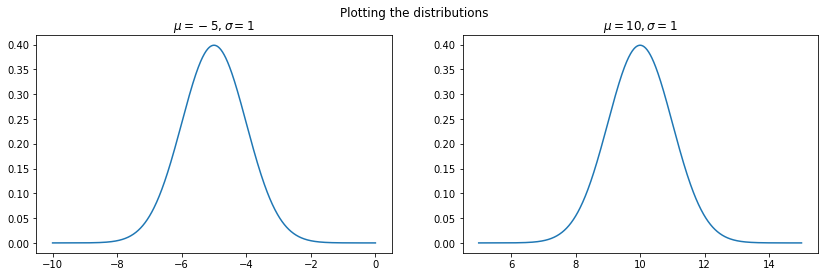

In [3]:
plt.figure(figsize=(14,4))
x = torch.linspace(mu1-5*sigma1,mu1+5*sigma1,1000)
plt.subplot(1,2,1)
plt.plot(x.numpy(),gaussian1.log_prob(x).exp().numpy())
plt.title(f'$\mu={mu1},\sigma={sigma1}$')

x = torch.linspace(mu2-5*sigma2,mu2+5*sigma2,1000)
plt.subplot(1,2,2)
plt.plot(x.numpy(),gaussian2.log_prob(x).exp().numpy())
plt.title(f'$\mu={mu2},\sigma={sigma2}$')

plt.suptitle('Plotting the distributions')

The above figure shows that the distributions have been correctly constructed.

Let us add the gaussians and generate a new distribution, $P(x)$. 

Our aim will be to approximate this new distribution
using another gaussian $Q(x)$. We will try to find the parameters $\mu_{Q},\sigma_{Q}$ by minimizing the KL divergence between the distributions $P(x)$ and $Q(x)$

Text(0.5, 1.0, '$P(X)$')

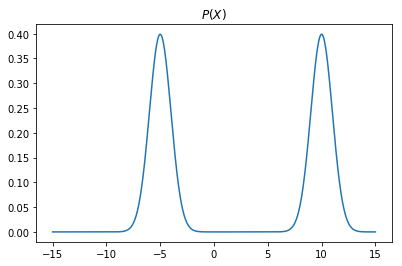

In [4]:
plt.figure(figsize=(14,4))
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
plt.subplot(1,2,2)
plt.plot(x.numpy(),px.numpy())
plt.title('$P(X)$')

## Constructing $Q(X)$

We will be using a gaussian distribution to approximate $P(X)$. We don't know the optimal paramters that will best approximate the distribution $P(x)$.

So, let us simply take $\mu=0,\sigma=1$ as our starting point. 

We could chosen better values, since we already have prior knowledge about the distribution that we are trying to approximate $(P(x))$. But this is mostly not the case in real scenarios

Text(0.5, 1.0, '$Q(X)$')

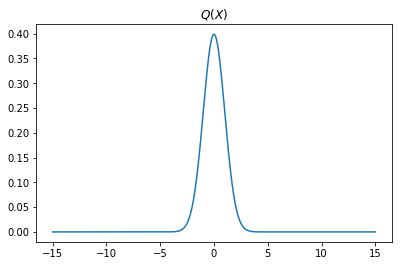

In [5]:
mu = torch.tensor([0.0])
sigma = torch.tensor([1.0])

plt.figure(figsize=(14,4))
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
Q = torch.distributions.Normal(mu,sigma) # this should approximate P, eventually :-)
qx = Q.log_prob(x).exp()
plt.subplot(1,2,2)
plt.plot(x.numpy(),qx.detach().numpy())
plt.title('$Q(X)$')

## KL-Divergence
$$D_{KL}(P(x)||Q(X)) = \sum_{x \in X} P(x) \log(P(x) / Q(x))$$


### Computing in pytorch

Pytorch provides function for computing KL Divergence. You can read more about it [here](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.kl_div).

The thing to note is that the input given is expected to contain log-probabilities. The targets are given as probabilities (i.e. without taking the logarithm).

So, the first argument to the function will be Q and second argument will be P (the target distribution).

Also, we have to be careful about numerical stabilty. 

In [6]:
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
qx = Q.log_prob(x).exp()
F.kl_div(qx.log(),px)

tensor(inf)

The Divergence is Infinity :-) I think this issue is caused when we exponentiate and then again take log. Using the log values directly seems to be fine.

In [7]:
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
qx = Q.log_prob(x)
F.kl_div(qx,px)

tensor(2.0812)

In [8]:
def optimize_loss(px: torch.tensor, loss_fn: str, muq: float = 0.0, sigmaq: float = 1.0,\
                  subsample_factor:int = 3,mode:str = 'min') -> Tuple[float,float,List[int]]:
    
    mu = torch.tensor([muq],requires_grad=True)
    sigma = torch.tensor([sigmaq],requires_grad=True)    

    opt = torch.optim.Adam([mu,sigma])

    loss_val = []
    epochs = 10000

    #required for animation
    all_qx,all_mu = [],[]
    subsample_factor = 3 #have to subsample to reduce memory usage

    torch_loss_fn = getattr(F,loss_fn)
    for i in range(epochs):
        Q = torch.distributions.Normal(mu,sigma) # this should approximate P
        if loss_fn!='kl_div': # we need to exponentiate q(x) for these and few other cases
            qx = Q.log_prob(x).exp()
            all_qx.append(qx.detach().numpy()[::subsample_factor])
        else:
            qx = Q.log_prob(x)
            all_qx.append(qx.exp().detach().numpy()[::subsample_factor])
            
        if mode=='min':
            loss = torch_loss_fn(qx,px)
        else:
            loss = -torch_loss_fn(qx,px,dim=0)
    #   backward pass
        opt.zero_grad()
        loss.backward()    
        opt.step()
        loss_val.append(loss.detach().numpy())
        all_mu.append(mu.data.numpy()[0])
        
        
        if i%(epochs//10)==0:
            print('Epoch:',i,'Loss:',loss.data.numpy(),'mu',mu.data.numpy()[0],'sigma',sigma.data.numpy()[0])


    print('Epoch:',i,'Loss:',loss.data.numpy(),'mu',mu.data.numpy()[0],'sigma',sigma.data.numpy()[0])
    
    plt.figure(figsize=(14,6))
    plt.subplot(2,2,1)
    plt.plot(loss_val)
    plt.xlabel('epoch')
    plt.ylabel(f'{loss_fn} (Loss)')
    plt.title(f'{loss_fn} vs epoch')
    
    plt.subplot(2,2,2)
    plt.plot(all_mu)
    plt.xlabel('epoch')
    plt.ylabel('$\mu$')
    plt.title('$\mu$ vs epoch')
    
    return mu.data.numpy()[0],sigma.data.numpy()[0],all_qx

Epoch: 0 Loss: 2.081249 mu 0.0009999981 sigma 1.001
Epoch: 1000 Loss: 0.73041373 mu 0.7143856 sigma 1.6610031
Epoch: 2000 Loss: 0.46422037 mu 1.192532 sigma 2.093055
Epoch: 3000 Loss: 0.3443205 mu 1.5722023 sigma 2.4694302
Epoch: 4000 Loss: 0.27543005 mu 1.8818176 sigma 2.8316045
Epoch: 5000 Loss: 0.23109896 mu 2.1264663 sigma 3.1971986
Epoch: 6000 Loss: 0.20085065 mu 2.304474 sigma 3.5747757
Epoch: 7000 Loss: 0.1796072 mu 2.4167948 sigma 3.96797
Epoch: 8000 Loss: 0.16454782 mu 2.4736757 sigma 4.3770604
Epoch: 9000 Loss: 0.1539281 mu 2.4945483 sigma 4.7997484
Epoch: 9999 Loss: 0.14657249 mu 2.4993849 sigma 5.2310653


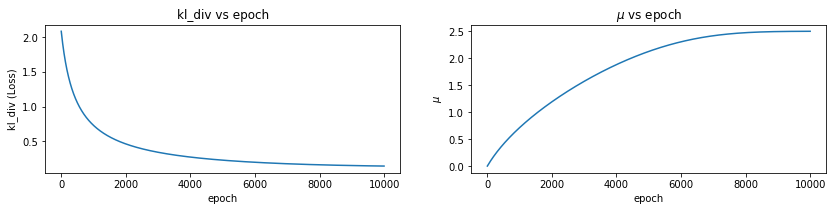

In [9]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu,sigma,all_qx = optimize_loss(px, loss_fn='kl_div', muq = 0.0, sigmaq = 1.0)

In [10]:
def create_animation(x:torch.tensor,px:torch.tensor,all_qx:List,subsample_factor:int = 3,\
                     fn:str = 'anim_distr.gif') -> None:

    # create a figure, axis and plot element 
    fig = plt.figure() 
    ax = plt.axes(xlim=(x.min(),x.max()), ylim=(0,0.5)) 
    text = ax.text(3,0.3,0)
    line1, = ax.plot([], [], color = "r")
    line2, = ax.plot([], [], color = "g",alpha=0.7)

    def animate(i):    
    #     non uniform sampling, interesting stuff happens fast initially
        if i<75:
            line1.set_data(x[::subsample_factor].numpy(),all_qx[i*50])
            text.set_text(f'epoch={i*50}')
            line2.set_data(x[::subsample_factor].numpy(),px.numpy()[::subsample_factor])
        else:
            line1.set_data(x[::subsample_factor].numpy(),all_qx[i*100])
            text.set_text(f'epoch={i*100}')
            line2.set_data(x[::subsample_factor].numpy(),px.numpy()[::subsample_factor])

        return [line1,line2]

    ani = matplotlib.animation.FuncAnimation(fig,animate,frames=100 
                                   ,interval=200, blit=True)

    fig.suptitle(f'Minimizing the {fn[:-3]}')
    ax.legend(['Approximation','Actual Distribution'])
    # save the animation as gif
    ani.save(fn, writer='imagemagick', fps=10) 

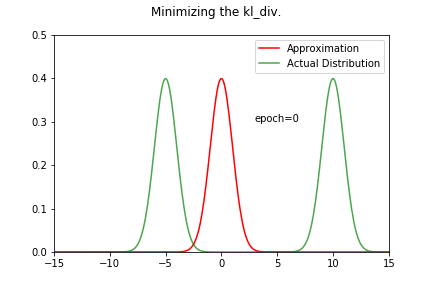

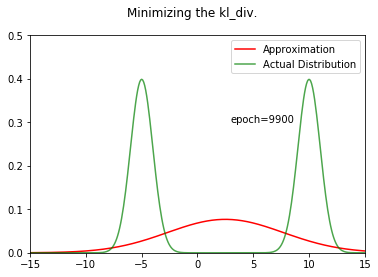

In [11]:
# %% capture if you dont want to display the final image
ani = create_animation(x,px,all_qx,fn='kl_div.gif')
Image("../working/kl_div.gif")

Let us try to see what we get when we try to solve the Mean Squared Distance between $P$ and $Q$

Epoch: 0 Loss: 0.028145002 mu -0.0009965245 sigma 1.0009999
Epoch: 1000 Loss: 0.02025735 mu -1.6213993 sigma 1.8781341
Epoch: 2000 Loss: 0.015503045 mu -2.833147 sigma 2.377313
Epoch: 3000 Loss: 0.01360773 mu -3.7208798 sigma 2.34772
Epoch: 4000 Loss: 0.010932032 mu -4.580743 sigma 1.6036143
Epoch: 5000 Loss: 0.009393812 mu -4.997196 sigma 1.0015959
Epoch: 6000 Loss: 0.009393757 mu -4.9999804 sigma 1.0000038
Epoch: 7000 Loss: 0.009393757 mu -4.999988 sigma 1.0000023
Epoch: 8000 Loss: 0.009393757 mu -4.999993 sigma 1.0000013
Epoch: 9000 Loss: 0.009393757 mu -4.9999957 sigma 1.0000008
Epoch: 9999 Loss: 0.009393757 mu -4.9999976 sigma 1.0000005


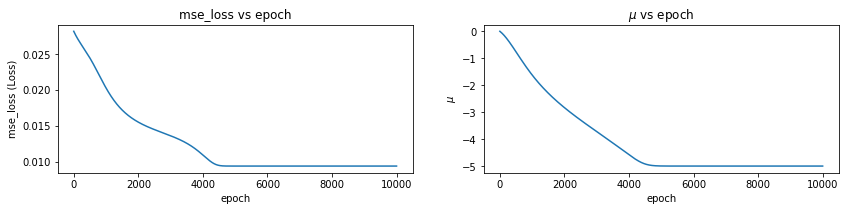

In [12]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu,sigma,all_qx = optimize_loss(px, loss_fn='mse_loss', muq = 0.0, sigmaq = 1.0)

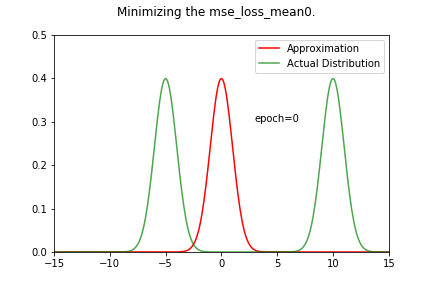

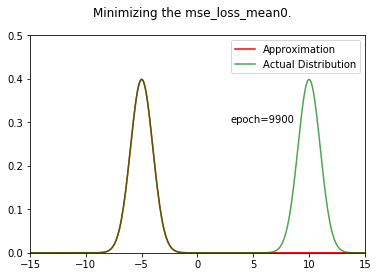

In [13]:
fn = 'mse_loss_mean0.gif'
ani = create_animation(x,px,all_qx,fn=fn)
Image(f"../working/{fn}")

We can see that the result is very different from the KL divergence case. We are converging towards one of the gaussians, no middle ground !

Also, you can try expeimenting with different initial values for $\mu_{Q}$. If you choose a value that is closer to 10 (mean of the second gaussian), it will converge towards it.

Epoch: 0 Loss: 0.028145002 mu 5.0009966 sigma 1.0009999
Epoch: 1000 Loss: 0.020257374 mu 6.62139 sigma 1.8781343
Epoch: 2000 Loss: 0.015503 mu 7.833145 sigma 2.3773263
Epoch: 3000 Loss: 0.013607591 mu 8.720935 sigma 2.3480563
Epoch: 4000 Loss: 0.010933896 mu 9.580524 sigma 1.6043035
Epoch: 5000 Loss: 0.009393813 mu 9.997191 sigma 1.0016034
Epoch: 6000 Loss: 0.009393757 mu 9.999961 sigma 1.0000038
Epoch: 7000 Loss: 0.009393757 mu 9.999976 sigma 1.0000023
Epoch: 8000 Loss: 0.009393757 mu 9.999986 sigma 1.0000013
Epoch: 9000 Loss: 0.009393757 mu 9.999991 sigma 1.0000008
Epoch: 9999 Loss: 0.009393757 mu 9.999995 sigma 1.0000005


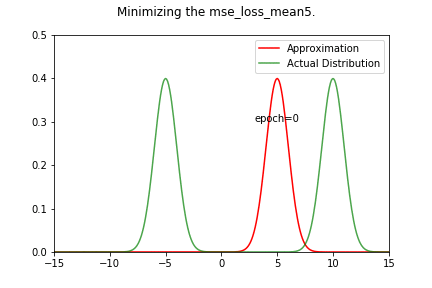

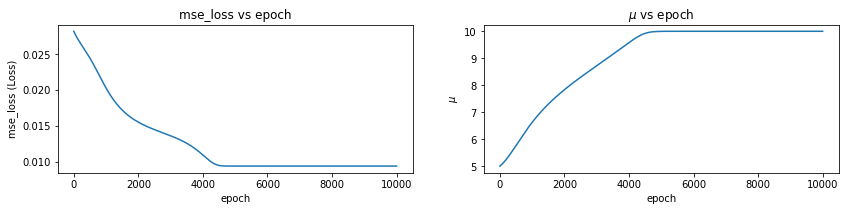

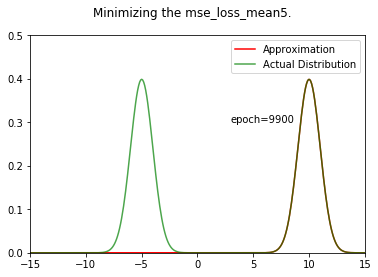

In [15]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu,sigma,all_qx = optimize_loss(px, loss_fn='mse_loss', muq = 5.0, sigmaq = 1.0)

fn = 'mse_loss_mean5.gif'
ani = create_animation(x,px,all_qx,fn=fn)
Image(f"../working/{fn}")

You can easily very this to be the case for L1 loss also. 

Now, let us try to see what we get when we try to maximize the cosine similarity between two distributions.


In [ ]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu,sigma,all_qx = optimize_loss(px, loss_fn='cosine_similarity', muq = 5.0, sigmaq = 1.0,mode='max')

fn = 'cosine_similarity.gif'
ani = create_animation(x,px,all_qx,fn=fn)
Image(f"../working/{fn}")

Epoch: 0 Loss: -0.0013650372 mu 5.001 sigma 1.0009999
Epoch: 1000 Loss: -0.25994527 mu 6.6144133 sigma 2.4433875
Epoch: 2000 Loss: -0.41905487 mu 7.6862497 sigma 2.9858646
Epoch: 3000 Loss: -0.501517 mu 8.562716 sigma 2.7770298
Epoch: 4000 Loss: -0.64180696 mu 9.502895 sigma 1.6784625
Epoch: 5000 Loss: -0.7070867 mu 9.990341 sigma 1.0044081
Epoch: 6000 Loss: -0.7071068 mu 9.999949 sigma 1.0000043
Epoch: 7000 Loss: -0.7071068 mu 9.9999695 sigma 1.0000027
Epoch: 8000 Loss: -0.7071068 mu 9.999982 sigma 1.0000017
Epoch: 9000 Loss: -0.7071069 mu 9.9999895 sigma 1.0000011
Epoch: 9999 Loss: -0.7071068 mu 9.999993 sigma 1.0000005


## Conclusion
As shown above in 1D case, we converge towards the nearest mean values. In a high dimensional space with multiple valleys, minimizing the MSE/L1 Loss can lead to different results.  In deep learning, we are randomly initializing the weights of neural network. So, it makes sense that we converge towards different local minimas in different runs of the same neural network. 
Techniques like stochastic weight averaging perhaps improve generalizibility because they offer weights to different local minimas. Its possible that different local minimas encode important information about the dataset.

In the next post, I will try to explore Wasserstein distance.